# Score Based Diffusion Models

## 📖 Explanation

Score-Based Diffusion Models are a class of generative models that generate new data by learning to reverse a gradual noise-adding process. The central idea is to start with clean data, such as images or audio, and slowly add random noise to it over time until it turns into pure noise. This is known as the diffusion (or forward) process. The model then learns to perform the reverse of this process — starting from random noise and progressively denoising it step by step until it forms a realistic data sample.

What makes these models unique is the use of a **"score function,"** which represents the gradient of the log probability density of the data. In simpler terms, the score function indicates the direction in which the data is more likely to exist in the noisy space. The model is trained to estimate this score function using a neural network at different noise levels. During generation, the model follows this learned score function, guiding noisy data back toward the distribution of real, clean data.

Score-Based Diffusion Models are known for their **stable training**, **excellent generation quality**, and **ability to model highly complex data distributions**, making them competitive alternatives to GANs and VAEs in tasks like image, audio, and graph generation.

![Diffusion Process Diagram](https://miro.medium.com/v2/resize:fit:617/1*cZeCmcEJxfbM1GcI8Q0dJw.png)


In this tutorial, we will perform image generation on MNIST using pytorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

**Score-Based Diffusion Models** use a **Variance Exploding Stochastic Differential Equation (VE-SDE)**.

## 1️⃣ Forward SDE
$$
d\mathbf{x} = \sigma^t d\mathbf{w}
$$
This equation represents the forward process in a variance-exploding stochastic differential equation (VE-SDE). Here, x is the data that is progressively noised over time, and $𝑑𝑤$ is the standard Wiener process (or Brownian motion), which models the random fluctuations in the system. The term $𝜎𝑡$ is a time-varying diffusion coefficient, controlling the scale of noise added at each time step. As time 𝑡 progresses, the noise added to the data grows exponentially because of the 𝜎𝑡 factor, thus making the data increasingly noisy. This process is crucial for training generative models, where clean data is gradually transformed into noise. The parameter 𝜎 determines how quickly the noise grows, and higher values of lead to a faster transition from clean data to pure noise.

## 2️⃣ Marginal Standard Deviation
$$
\text{marginal_std}(t) = \sqrt{\frac{\sigma^{2t} - 1}{2 \log \sigma}}
$$
This equation calculates the marginal standard deviation of the data at a given time step 𝑡 in the forward diffusion process. The standard deviation indicates how much noise has been added to the data at each step. The formula shows that the noise grows exponentially with $𝜎^{2𝑡}$ but the growth is normalized by the term 2log𝜎 to ensure a smooth and controllable increase in noise over time. The marginal standard deviation provides a way to track how the variance of the noised data increases as the diffusion process evolves. It’s an important quantity for understanding the noise schedule, as it dictates how much perturbation is introduced at each time step. Larger values of
𝜎 lead to a faster increase in noise variance.

## 3️⃣ Diffusion Coefficient
$$g(t) = \sigma^t$$

This equation defines the diffusion coefficient at time 𝑡, denoted as 𝑔(𝑡). The diffusion coefficient determines how much noise is added to the data at any given time step. It is an exponential function of time, with the rate of increase controlled by 𝜎. As 𝑡 increases, the diffusion coefficient grows, meaning the data is increasingly corrupted by noise. This relationship is fundamental to the forward SDE, as it describes the scale of the noise at each time step, which affects the amount of randomness added to the data. The choice of 𝜎 thus plays a crucial role in shaping the noise dynamics during the training of diffusion-based generative models. Higher values of 𝜎 lead to a stronger and faster diffusion process.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def marginal_prob_std(t, sigma):
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.)/2./np.log(sigma))

def diffusion_coeff(t, sigma):
  return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

## GaussianFourierProjection

This `GaussianFourierProjection` class implements **Gaussian random Fourier features** for encoding continuous values like time steps (or noise levels in diffusion models) into a higher-dimensional space.

It’s based on the idea that instead of directly using raw scalar values like time, you can **project them into a richer space** using sinusoidal functions (sin and cos) with randomly sampled frequencies — giving the model a way to better capture periodic and multi-scale patterns in continuous values.

This is similar in spirit to positional encodings in Transformers, but with **random Gaussian-distributed frequencies**.


## ✍️ What it does — Step by Step

- **Input:** A tensor `x` of shape `[batch_size]`, where each element is a scalar (like a time step).
- **Projection:**  
  Multiplies each value `x` by a set of **fixed, randomly sampled frequencies `W`** and `2π`.
- **Feature Mapping:**  
  Applies sine and cosine to the projected values.
- **Output:**  
  Concatenates the sine and cosine values along the last dimension, producing a **2 × (embed_dim // 2)**-dimensional feature vector for each input `x`.


## 📝 The Equation

$
\text{Fourier}(x) =
\begin{bmatrix}
\sin(2\pi x W_1), \sin(2\pi x W_2), \dots, \sin(2\pi x W_{D/2}), \\
\cos(2\pi x W_1), \cos(2\pi x W_2), \dots, \cos(2\pi x W_{D/2})
\end{bmatrix}
$

Or in vector form:

$\mathrm{Fourier}(x) = \operatorname{concat}\left(\sin(2\pi x \mathbf{W}),\ \cos(2\pi x \mathbf{W})\right)$



## 🎨 Why Use This?

In score-based diffusion models, time steps are continuous and scalar — but neural networks work better with richer, high-dimensional inputs.  
Encoding time steps using random Fourier features lets the network capture more **complex, multi-scale variations** associated with different noise levels.


In [6]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2* np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

Now, we will define our noise prediction model:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Dense(nn.Module):
    """A simple dense layer."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x).unsqueeze(-1).unsqueeze(-1)
class ScoreNet(nn.Module):
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    super().__init__()
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim))

    # Encoding layers where the resolution decreases self.conv1 = nn.Conv2d(1, channels [0], 3, stride=1, bias=False)
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.densel = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels [1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels [2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4=nn.GroupNorm(32, num_channels=channels[3])

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2]+channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1]+channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0]+channels[0], 1, 3, stride=1)

    self.act = lambda x: x* torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std


  def forward(self, x, t):
    # 0
    embed=self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## 合并来自 t 的信息
    h1+= self.densel(embed) ## 组标准化
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2+= self.dense2(embed)
    h2= self.gnorm2(h2)
    h2= self.act(h2)
    h3 = self.conv3(h2)
    h3+= self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4= self.conv4(h3)
    h4+= self.dense4(embed)
    h4= self.gnorm4(h4)
    h4 = self.act(h4)
    # Decoding path
    h = self.tconv4(h4) ## 从编码路径跳过连接
    h+= self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat ( [h, h3], dim=1))
    h+= self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h+= self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))
    # Normalize output
    h = h / self.marginal_prob_std(t) [:, None, None, None]
    return h

## Training Diffusion Models
The goal of training a score-based generative model involves minimizing the loss between the model’s predicted score (gradient of the log-likelihood) and the true noise added during the forward diffusion process.

## 1️⃣ Random Time Step \( t \)

For each input, a random time step $t$ is chosen uniformly from the interval $[\epsilon, 1]$, where $epsilon$ is a small constant to avoid extreme values of $t$.


$$t_i = \text{uniform}(\epsilon, 1)$$

where $t_i$ represents the randomly chosen time step for the $i$-th sample.



## 2️⃣ Noise Generation

Random noise $z_i$ is generated for each data point. This noise follows a standard normal distribution with zero mean and unit variance:

$$z_i \sim \mathcal{N}(0, I)$$

where $\mathcal{N}(0, I)$ represents a normal distribution with mean 0 and variance 1.


## 3️⃣ Perturbed Data

To simulate the diffusion process, the original data $\mathbf{x}_i$ is perturbed by adding noise. The amount of noise is scaled by the marginal standard deviation $\sigma(t)$ at the given time step $t$:

$$\mathbf{x}_i(t) = \mathbf{x}_i + z_i \cdot \sigma(t)$$

Here, $\mathbf{x}_i(t)$ represents the perturbed version of the input $\mathbf{x}_i$ at time step $t$, and $\sigma(t)$ is the standard deviation at time $t$ which controls how much noise is added.


## 4️⃣ Score Prediction

The model predicts the score, which is the gradient of the log-probability of the noisy data with respect to the clean data. This score can be written as:

$$\hat{\nabla_{\mathbf{x}} \log p_t(\mathbf{x}_i)} = \text{model}(\mathbf{x}_i(t), t)$$

where $\hat{\nabla_{\mathbf{x}} \log p_t(\mathbf{x}_i)}$ is the model’s predicted score for the noisy data at time step $t$.

In [8]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  random_t = torch.rand(x.shape[0], device=x.device) * (1. -eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [9]:
from tqdm import tqdm

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)

n_epochs = 50
batch_size=32
lr=1e-4

dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = Adam(score_model.parameters(), lr=lr)
for epoch in tqdm(range(n_epochs)):
  avg_loss = 0.
  num_items = 0
  for x,y in data_loader:

    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  print(f"Epoch {epoch} loss: {avg_loss / num_items}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 55.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.15MB/s]
  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-2-f736811610a8>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  2%|▏         | 1/50 [00:24<19:57, 24.44s/it]

Epoch 0 loss: 257.9670961181641


  4%|▍         | 2/50 [00:49<19:38, 24.56s/it]

Epoch 1 loss: 64.61077633870443


  6%|▌         | 3/50 [01:09<17:42, 22.61s/it]

Epoch 2 loss: 44.67699158528646


  8%|▊         | 4/50 [01:29<16:41, 21.76s/it]

Epoch 3 loss: 35.804407983398434


 10%|█         | 5/50 [01:51<16:12, 21.61s/it]

Epoch 4 loss: 31.06415128173828


 12%|█▏        | 6/50 [02:11<15:24, 21.01s/it]

Epoch 5 loss: 28.117498068237303


 14%|█▍        | 7/50 [02:31<14:55, 20.82s/it]

Epoch 6 loss: 26.31431971995036


 16%|█▌        | 8/50 [02:51<14:28, 20.68s/it]

Epoch 7 loss: 24.972980507914226


 18%|█▊        | 9/50 [03:11<13:57, 20.43s/it]

Epoch 8 loss: 23.934090159606935


 20%|██        | 10/50 [03:32<13:35, 20.39s/it]

Epoch 9 loss: 23.226691246541343


 22%|██▏       | 11/50 [03:52<13:15, 20.40s/it]

Epoch 10 loss: 22.83878898264567


 24%|██▍       | 12/50 [04:12<12:52, 20.32s/it]

Epoch 11 loss: 21.95995562693278


 26%|██▌       | 13/50 [04:32<12:28, 20.23s/it]

Epoch 12 loss: 21.767540334065757


 28%|██▊       | 14/50 [04:52<12:09, 20.26s/it]

Epoch 13 loss: 21.56311714324951


 30%|███       | 15/50 [05:13<11:50, 20.30s/it]

Epoch 14 loss: 20.995974676513672


 32%|███▏      | 16/50 [05:33<11:26, 20.20s/it]

Epoch 15 loss: 20.55952275543213


 34%|███▍      | 17/50 [05:53<11:08, 20.25s/it]

Epoch 16 loss: 20.568028920491535


 36%|███▌      | 18/50 [06:14<10:49, 20.31s/it]

Epoch 17 loss: 20.52546210276286


 38%|███▊      | 19/50 [06:33<10:25, 20.16s/it]

Epoch 18 loss: 20.319194311523436


 40%|████      | 20/50 [06:54<10:07, 20.24s/it]

Epoch 19 loss: 20.016242327372233


 42%|████▏     | 21/50 [07:14<09:49, 20.32s/it]

Epoch 20 loss: 19.766834267171223


 44%|████▍     | 22/50 [07:34<09:26, 20.24s/it]

Epoch 21 loss: 19.515685414632163


 46%|████▌     | 23/50 [07:55<09:05, 20.22s/it]

Epoch 22 loss: 19.557123156229654


 48%|████▊     | 24/50 [08:15<08:46, 20.26s/it]

Epoch 23 loss: 19.345329479980467


 50%|█████     | 25/50 [08:35<08:27, 20.28s/it]

Epoch 24 loss: 19.160903871154787


 52%|█████▏    | 26/50 [08:55<08:03, 20.14s/it]

Epoch 25 loss: 19.060871956888835


 54%|█████▍    | 27/50 [09:15<07:44, 20.21s/it]

Epoch 26 loss: 18.967994464619956


 56%|█████▌    | 28/50 [09:36<07:25, 20.25s/it]

Epoch 27 loss: 18.822264993286133


 58%|█████▊    | 29/50 [09:56<07:02, 20.12s/it]

Epoch 28 loss: 18.763067070007324


 60%|██████    | 30/50 [10:16<06:44, 20.20s/it]

Epoch 29 loss: 18.823481572977702


 62%|██████▏   | 31/50 [10:36<06:24, 20.26s/it]

Epoch 30 loss: 18.455608180745443


 64%|██████▍   | 32/50 [10:56<06:02, 20.13s/it]

Epoch 31 loss: 18.532704150899253


 66%|██████▌   | 33/50 [11:17<05:43, 20.20s/it]

Epoch 32 loss: 18.32878166910807


 68%|██████▊   | 34/50 [11:37<05:23, 20.24s/it]

Epoch 33 loss: 18.23810399424235


 70%|███████   | 35/50 [11:57<05:02, 20.16s/it]

Epoch 34 loss: 18.152474941507975


 72%|███████▏  | 36/50 [12:17<04:42, 20.19s/it]

Epoch 35 loss: 18.30706468149821


 74%|███████▍  | 37/50 [12:38<04:23, 20.24s/it]

Epoch 36 loss: 18.134299361165365


 76%|███████▌  | 38/50 [12:58<04:02, 20.24s/it]

Epoch 37 loss: 17.992009645080568


 78%|███████▊  | 39/50 [13:18<03:41, 20.13s/it]

Epoch 38 loss: 18.062585395812988


 80%|████████  | 40/50 [13:38<03:22, 20.25s/it]

Epoch 39 loss: 18.111857008870444


 82%|████████▏ | 41/50 [13:59<03:02, 20.29s/it]

Epoch 40 loss: 18.115509023030597


 84%|████████▍ | 42/50 [14:18<02:41, 20.14s/it]

Epoch 41 loss: 17.960147673543293


 86%|████████▌ | 43/50 [14:40<02:24, 20.66s/it]

Epoch 42 loss: 17.82070174407959


 88%|████████▊ | 44/50 [15:01<02:03, 20.58s/it]

Epoch 43 loss: 17.87858057912191


 90%|█████████ | 45/50 [15:20<01:41, 20.36s/it]

Epoch 44 loss: 17.850919614664715


 92%|█████████▏| 46/50 [15:41<01:21, 20.33s/it]

Epoch 45 loss: 17.666523423258464


 94%|█████████▍| 47/50 [16:03<01:02, 20.83s/it]

Epoch 46 loss: 17.680805074564617


 96%|█████████▌| 48/50 [16:24<00:41, 20.83s/it]

Epoch 47 loss: 17.481308493041993


 98%|█████████▊| 49/50 [16:44<00:20, 20.59s/it]

Epoch 48 loss: 17.557616735839844


100%|██████████| 50/50 [17:04<00:00, 20.49s/it]

Epoch 49 loss: 17.424508774820964


# Euler-Maruyama Sampler for Score-based Diffusion Models

In score-based generative models, one approach for sampling from the reverse diffusion process is to use numerical methods to approximate the reverse SDE (Stochastic Differential Equation). One of the widely-used methods is the **Euler-Maruyama method**, which discretizes the reverse SDE into smaller time steps, enabling the model to iteratively generate samples from noise. This method is particularly useful for score-based models, where the score function (the gradient of the log-probability) is learned to reverse the forward diffusion process.

## Euler-Maruyama Sampler Algorithm

The **Euler-Maruyama sampler** is implemented as follows:

### 1️⃣ Initialization

The process begins with a random initialization of $\mathbf{x}_0$, drawn from a normal distribution scaled by the marginal standard deviation at time step $t_0 = 1$:

$$\mathbf{x}_0 \sim \mathcal{N}(0, \sigma(t_0)^2)$$

where $\sigma(t)$ represents the standard deviation at time step $t$.


### 2️⃣ Time Steps

The time steps are discretized from $t = 1$ to $t = \epsilon$ (a small value). The time steps are sampled in reverse order, from $t_0 = 1$ down to $t_1 = \epsilon$.

The time steps are defined as:

$$t_i \in [1, \epsilon] \quad \text{with step size} \quad \Delta t = t_{i-1} - t_i$$


### 3️⃣ Diffusion Coefficient

At each time step, the diffusion coefficient $g(t)$ is calculated as $\sigma(t)$, which is used to scale the noise in the sampling process:

$$g(t) = \sigma(t)$$


### 4️⃣ Score Model Prediction

At each time step $t$, the model predicts the score $\hat{\nabla_{\mathbf{x}} \log p_t(\mathbf{x}_t)}$, which is the gradient of the log-probability of the noisy data at time $t$. The score is used to guide the sampling process.

$$\hat{\nabla_{\mathbf{x}} \log p_t(\mathbf{x}_t)} = \text{score\_model}(\mathbf{x}_t, t)$$


### 5️⃣ Updating the Sample

The next step in the process is computed using the Euler-Maruyama discretization:

$$
\mathbf{x}_{i+1} = \mathbf{x}_i + g(t_i)^2 \cdot \hat{\nabla_{\mathbf{x}} \log p_t(\mathbf{x}_i)} \cdot \Delta t + \sqrt{\Delta t} \cdot g(t_i) \cdot \mathcal{N}(0, I)
$$

where $\mathcal{N}(0, I)$ is a standard normal random variable, and $g(t_i)$ is the diffusion coefficient at time step $t_i$.


## Significance of the Euler-Maruyama Sampler

The **Euler-Maruyama method** is significant for score-based generative models as it provides a simple and computationally efficient way to sample from complex distributions defined by reverse diffusion processes. This method is based on discretizing the reverse-time stochastic differential equation (SDE), which is used to model the process of denoising data samples through iterative steps.

In [10]:
num_steps = 500

def Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, num_steps=num_steps, device='cuda', eps=1e-3):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  return mean_x

# Predictor-Corrector (PC) Sampler for Score-Based Diffusion Models

The **Predictor-Corrector (PC) Sampler** is an advanced sampling algorithm for score-based generative models, combining both deterministic and stochastic updates at each time step. It improves upon the Euler-Maruyama sampler by integrating a **Predictor** step (to deterministically guide the sample towards higher density regions) and a **Corrector** step (to refine the sample via Langevin dynamics). This two-step process ensures better sample quality and stability.



## PC Sampler Algorithm

### 1️⃣ Initialization

Start by sampling the initial noisy data $\mathbf{x}_0$ from a scaled normal distribution:

$$
\mathbf{x}_0 \sim \mathcal{N}\left(0, \text{marginal\_std}(1)^2\right)
$$



### 2️⃣ Time Discretization

The continuous time interval is discretized into $N$ equally spaced time steps from $t = 1$ to $t = \epsilon$:

$$
t_i \in [1, \epsilon], \quad \text{with step size} \ \Delta t = t_{i-1} - t_i
$$



### 3️⃣ Corrector Step (Langevin MCMC)

At each time step $t_i$, the **Langevin MCMC** update refines the sample by adding a scaled score gradient and Gaussian noise. The update is:

- **Gradient Norm:**
  $$
  \|\nabla \log p_t(\mathbf{x})\| = \text{grad_norm}
  $$

- **Noise Norm:**
  $$
  \|\boldsymbol{\eta}\| = \sqrt{\text{dim}(\mathbf{x})}
  $$

- **Langevin Step Size:**
  $$
  s = 2 \left( \frac{\text{SNR} \times \|\boldsymbol{\eta}\|}{\|\nabla \log p_t(\mathbf{x})\|} \right)^2
  $$

- **Corrector Update:**
  $$
  \mathbf{x} \leftarrow \mathbf{x} + s \cdot \nabla \log p_t(\mathbf{x}) + \sqrt{2s} \cdot \mathcal{N}(0, I)
  $$



### 4️⃣ Predictor Step (Reverse SDE)

After the Corrector step, the **Predictor** step approximates the reverse-time SDE using the Euler-Maruyama method:

- **Diffusion Coefficient:**
  $$
  g(t) = \sigma^t
  $$

- **Mean Update:**
  $$
  \mathbf{x}_{\text{mean}} = \mathbf{x} + g(t)^2 \cdot \nabla \log p_t(\mathbf{x}) \cdot \Delta t
  $$

- **Predictor Update:**
  $$
  \mathbf{x} \leftarrow \mathbf{x}_{\text{mean}} + \sqrt{g(t)^2 \cdot \Delta t} \cdot \mathcal{N}(0, I)
  $$



## Significance of the Predictor-Corrector (PC) Sampler

The **PC sampler** improves sampling quality and convergence in score-based diffusion models through:

- **Corrector (Langevin MCMC):**  
  Refines the sample by iteratively adjusting it towards high-density regions of the learned data distribution using score gradients. It balances the score and noise via an adaptive step size based on the Signal-to-Noise Ratio (SNR).

- **Predictor (Reverse SDE):**  
  Progresses the sample through time using a deterministic approximation of the reverse SDE while incorporating controlled stochasticity.

In [11]:
signal_to_noise_ratio = 0.16

num_steps = 500

def pc_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64,
               num_steps=num_steps, snr=signal_to_noise_ratio, device='cuda',
               eps=1e-3):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1,28,28, device=device) * marginal_prob_std(t)[:, None, None, None]

  time_steps = np.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # langvein mcmc
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langvein_step_size = 2 * (snr * noise_norm/grad_norm) ** 2
      x = x + langvein_step_size * grad + torch.sqrt(2 * langvein_step_size) * torch.randn_like(x)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x + torch.sqrt(g**2 * step_size) * g[:, None, None, None] * torch.randn_like(x)
  return x_mean

# ODE-Based Sampler for Score-Based Diffusion Models

The **ODE Sampler** is a deterministic method for generating samples from score-based generative models by solving the corresponding **probability flow ordinary differential equation (ODE)**. Unlike stochastic samplers that rely on random noise, this method integrates a differential equation that deterministically evolves the sample from noise to data, using black-box ODE solvers such as Runge-Kutta.


## 1️⃣ Probability Flow ODE

The reverse-time stochastic differential equation (SDE) can be converted into a deterministic ODE known as the **probability flow ODE**:

$$
\frac{d\mathbf{x}(t)}{dt} = -\frac{1}{2} g(t)^2 \nabla_{\mathbf{x}} \log p_t(\mathbf{x})
$$

Where:
- $\mathbf{x}(t)$ is the sample at time $t$
- $g(t)$ is the diffusion coefficient at time $t$
- $\nabla_{\mathbf{x}} \log p_t(\mathbf{x})$ is the **score function** learned by the score-based model


## 2️⃣ ODE Function

The ODE function used by the solver is:

$$
f(t, \mathbf{x}) = -\frac{1}{2} g(t)^2 \cdot \text{score_model}(\mathbf{x}, t)
$$

At each step:
- The score function is evaluated at the current sample and time step
- The value is scaled by $-0.5 \times g(t)^2$


## Significance of the ODE Sampler

The **ODE Sampler** offers a clean, noise-free, and deterministic alternative to stochastic samplers:

- **Deterministic generation:**  
  Unlike Langevin-based or SDE samplers, this method avoids stochastic noise during sampling, resulting in deterministic, reproducible outputs.

- **Black-box integration:**  
  It leverages standard ODE solvers like **RK45** to automatically handle step sizes and errors, simplifying the implementation.

- **High-quality samples:**  
  By accurately integrating the probability flow ODE, this method often produces samples of competitive or superior quality compared to stochastic counterparts.

- **Supports latent sampling:**  
  The sampler can be initialized from a given latent code $\mathbf{z}$, enabling controlled generation or latent-guided tasks.

In [13]:
from scipy import integrate

error_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):
    """Generate samples from score-based models with black-box ODE solvers.

    Args:
      score_model: A PyTorch model that represents the time-dependent score-based model.
      marginal_prob_std: A function that returns the standard deviation
        of the perturbation kernel.
      diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
      batch_size: The number of samplers to generate by calling this function once.
      atol: Tolerance of absolute errors.
      rtol: Tolerance of relative errors.
      device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
      z: The latent code that governs the final sample. If None, we start from p_1;
        otherwise, we start from the given z.
      eps: The smallest time step for numerical stability.
    """
    t = torch.ones(batch_size, device=device)
    # Create the latent code
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z

    shape = init_x.shape

    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0],))
        with torch.no_grad():
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)

    def ode_func(t, x):
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return -0.5 * (g ** 2) * score_eval_wrapper(x, time_steps)

    # Run the black-box ODE solver.
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol,
                              method='RK45')
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

    return x

# Visualizing Results

<ipython-input-2-f736811610a8>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-2-f736811610a8>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 374


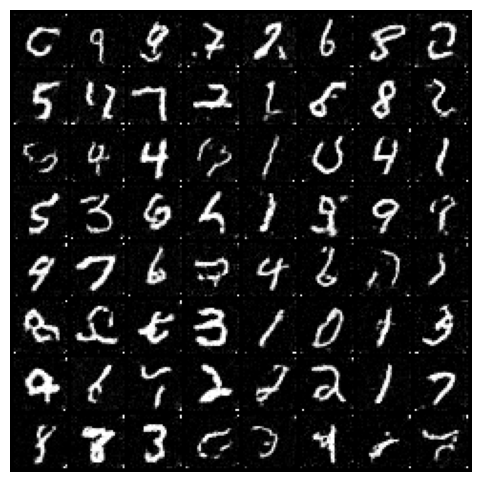

In [14]:
from torchvision.utils import make_grid

sample_batch_size = 64
sampler = ode_sampler

samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=sample_batch_size, device=device)
samples = samples.clamp(0,1)
import matplotlib.pyplot as plt
samples_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
plt.figure(figsize=(6,6))
plt.imshow(samples_grid.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()